In [1]:
# Factor Analysis를 통해 대략적인 경향성을 파악
# 단 roc_auc_score가 높지 않으므로 이후 다른 파일에서 각 Feature들을 세부적으로 뜯어서 분석 예정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smfa

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import make_pipeline
from factor_analyzer import FactorAnalyzer

In [4]:
from data.utils import add_experience, feature_classification, astype_category

In [5]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [6]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [7]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [8]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [9]:
# Standard Scaler 진행
scaler = StandardScaler().fit(X)
X_sc = scaler.transform(X)

In [10]:
# Factor analysis를 통한 Factor 확인
# Dimensionality Reduction 이후 Variance 설명량을 확인하여 적절한 factor 개수 추출
cumul_var_list = []
for i in range(3, 50):
    fa = FactorAnalyzer(n_factors=i, method='principal', rotation='varimax').fit(X_sc)
    cumul_var_list.append(fa.get_factor_variance()[2][i-1])
np.array(cumul_var_list)

array([0.20608721, 0.25222376, 0.2893682 , 0.32482034, 0.35815825,
       0.39003412, 0.41997676, 0.44876959, 0.47616802, 0.50256196,
       0.52766375, 0.55187591, 0.57644902, 0.59921788, 0.62147352,
       0.64264125, 0.66326924, 0.68361028, 0.70381067, 0.72368677,
       0.74291487, 0.76168947, 0.77995457, 0.79792148, 0.81523364,
       0.83227569, 0.84900917, 0.86559946, 0.88176429, 0.89768792,
       0.91272463, 0.92702985, 0.93927324, 0.94942109, 0.9585669 ,
       0.96732173, 0.97473727, 0.98094771, 0.98582011, 0.98971396,
       0.99353061, 0.99567085, 0.99708568, 0.99849442, 0.9993969 ,
       1.        , 1.02365641])

In [11]:
# Variance 설명량이 60%가 넘는 n_factors를 선택하여 Factor Loadings 확인
n_factors = 17
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_sc)
fl_matrix = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X.columns)
fl_matrix

,Factor01,Factor02,Factor03,Factor04,Factor05,Factor06,Factor07,Factor08,Factor09,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17
MonthlyIncome,0.853112,0.048425,0.342935,-0.002229,0.019648,-0.002123,-0.027512,-0.020166,0.051695,-0.007744,-0.057871,0.018668,-0.008477,0.072609,-0.116938,0.022519,-0.000653
PercentSalaryHike,-0.006718,-0.023198,-0.022272,-0.019220,0.003283,-0.007654,0.014406,0.934696,-0.018929,0.007265,0.001841,-0.011471,0.023622,0.017060,-0.003699,0.000159,-0.004415
StockOptionLevel,-0.009066,0.009834,0.010117,-0.012643,0.860137,0.001685,0.015524,0.003616,0.014218,0.024792,0.005524,0.151349,0.005423,0.011766,0.057477,-0.004390,0.011346
Age,0.691093,-0.012532,0.102819,0.007227,0.045501,0.031977,-0.002215,0.012086,0.131380,-0.003162,0.159180,-0.044305,0.012526,-0.050423,0.229476,0.019305,0.019462
DistanceFromHome,-0.050577,0.056664,0.031940,-0.026037,0.032177,-0.001086,0.071281,0.076844,0.001530,0.083482,-0.032197,-0.048989,0.039590,0.069161,0.290429,0.065416,0.031971
NumCompaniesWorked,0.281236,-0.006830,-0.189047,0.028011,0.006666,0.039516,-0.025420,-0.008121,0.671750,0.036599,0.095329,0.014038,-0.004337,-0.050090,0.149279,-0.026439,-0.003126
TotalWorkingYears,0.831715,-0.026073,0.382171,-0.010933,0.002203,0.025063,-0.009011,0.002695,0.062275,0.017246,0.048018,-0.005039,0.003347,0.000731,0.097450,0.008731,-0.001220
JobLevel,0.839603,0.106895,0.365470,-0.017791,0.018395,0.009218,-0.004196,-0.025625,0.038963,-0.015162,-0.056978,0.025959,0.006036,0.050759,-0.053452,0.050147,0.043419
JobInvolvement,-0.008169,-0.018621,-0.008580,0.008219,0.042160,-0.027039,-0.040759,-0.045503,-0.027035,0.020959,0.020991,-0.031616,-0.012586,0.088682,0.207266,0.045774,-0.050023
OverTime,0.004757,0.001693,-0.041954,-0.003306,-0.000694,0.051983,0.028335,-0.005196,-0.010675,0.006252,0.104782,0.038867,-0.044184,0.079945,0.021753,0.407639,-0.026585


In [12]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df = (pd.concat([fl_matrix.idxmax(axis=1), fl_matrix.max(axis=1)], axis=1)
         .rename({0:'Idxmax', 1:'Max'}, axis=1)
         .sort_values(by='Idxmax', ascending=True)
)
fl_df

,Idxmax,Max
MonthlyIncome,Factor01,0.853112
Age,Factor01,0.691093
JobRole_Manager,Factor01,0.533891
TotalWorkingYears,Factor01,0.831715
JobLevel,Factor01,0.839603
JobRole_ResearchDirector,Factor01,0.425075
BusinessTravel_Travel_Rarely,Factor01,0.033151
Experienced_ExpEmp,Factor01,0.691611
EducationField_Marketing,Factor02,0.682078
Department_Sales,Factor02,0.956303


In [13]:
# Max Factor Loadings가 0.5 이하인 Features를 택하여 해당 Features를 제거
not_sig_feats_in_fa = (fl_df
                       .query("Max < 0.5")
                       .index
)
not_sig_feats_in_fa = not_sig_feats_in_fa.to_list()
X_remove = X.drop(not_sig_feats_in_fa, axis=1)

In [14]:
# Standard Scaler 진행
scaler = StandardScaler().fit(X_remove)
X_remove_sc = scaler.transform(X_remove)

In [15]:
# 기존 설정한 n_factors를 바탕으로 다시 fl_matrix 확인
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_remove_sc)
fl_matrix_changed = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X_remove.columns)
fl_matrix_changed

,Factor01,Factor02,Factor03,Factor04,Factor05,Factor06,Factor07,Factor08,Factor09,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17
MonthlyIncome,0.361904,0.256841,-0.015287,0.075421,-0.021322,0.009891,-0.007451,-0.034343,0.129877,0.822254,-0.008487,0.000230,0.004616,-0.021128,0.003552,-0.042050,-0.068777
PercentSalaryHike,-0.017103,0.010636,-0.017437,-0.012393,0.941180,-0.004728,0.011227,-0.014990,-0.002276,-0.014753,-0.012874,-0.007522,0.014862,-0.001212,0.020002,-0.012598,-0.004296
StockOptionLevel,0.009653,0.016679,0.003225,0.001988,0.009875,0.869917,0.029248,0.003112,0.018718,-0.026210,-0.025848,0.014057,0.028444,0.013546,0.029104,0.041065,0.310160
Age,0.315704,0.517518,0.007377,-0.092506,0.008373,0.021194,-0.015014,0.088092,0.427965,0.300938,0.008520,0.016594,0.016778,0.174162,0.006127,0.173900,-0.007241
NumCompaniesWorked,-0.111781,0.027152,0.018735,0.008639,-0.007999,0.024469,-0.008236,-0.024186,0.948287,0.080527,-0.022865,0.020899,0.008027,0.029001,-0.014155,-0.034657,0.007083
TotalWorkingYears,0.554766,0.467532,-0.011354,-0.042644,-0.005362,0.005346,-0.019713,-0.014170,0.272611,0.536259,0.011806,0.018125,0.029386,0.029647,-0.009156,0.029919,-0.049697
JobLevel,0.405048,0.280463,-0.022944,0.147021,-0.026964,0.017740,-0.007263,-0.016228,0.139769,0.770131,0.001807,0.006871,-0.004295,-0.029227,0.005328,-0.042714,-0.090091
YearsAtCompany,0.881055,-0.098556,-0.000201,-0.009117,-0.019492,0.001181,-0.004990,0.003654,-0.050432,0.310398,0.013077,-0.000431,0.025490,0.038915,0.011044,0.037498,-0.000091
YearsInCurrentRole,0.874424,-0.062038,-0.028420,0.047690,0.020868,0.029166,0.019685,-0.039013,-0.029937,0.084442,-0.016616,0.023787,-0.038287,-0.017860,0.022670,-0.026252,0.012989
YearsSinceLastPromotion,0.684778,-0.030021,-0.019522,0.028469,-0.008251,0.004534,-0.004697,0.001473,0.024541,0.150156,0.034227,-0.012746,0.030083,0.002626,-0.012551,-0.035870,0.517796


In [16]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df_changed = (pd.concat([fl_matrix_changed.idxmax(axis=1), fl_matrix_changed.max(axis=1)], axis=1)
                 .rename({0:'Idxmax', 1:'Max'}, axis=1)
                 .sort_values(by='Idxmax', ascending=True)
)
fl_df_changed

,Idxmax,Max
TotalWorkingYears,Factor01,0.554766
YearsAtCompany,Factor01,0.881055
YearsInCurrentRole,Factor01,0.874424
YearsSinceLastPromotion,Factor01,0.684778
YearsWithCurrManager,Factor01,0.876315
Age,Factor02,0.517518
Experienced_ExpEmp,Factor02,0.878248
JobRole_HumanResources,Factor03,0.923553
EducationField_HumanResources,Factor03,0.795523
Department_HumanResources,Factor03,0.956566


In [17]:
# Factor들에 대한 해석
factor_interpret = {'Factor01':'ManagingPosition', 'Factor02':'WorkExp', 'Factor03':'HRPosition', 'Factor04':'SalesPosition',
                    'Factor05':'Performance', 'Factor06':'Divorced_StockOption', 'Factor07':'EnvUnsatisfied',
                    'Factor08':'LowEducation', 'Factor09':'MoveFrequent', 'Factor10':'HighJobLevel', 'Factor11':'TravelFrequent',
                    'Factor12':'GenderFemale', 'Factor13':'MajorMedical', 'Factor14':'HighEducation', 'Factor15':'EnvSatisfied',
                    'Factor16':'MajorMarkeing', 'Factor17':'Factor17'}

In [18]:
# Factor analysis 반영한 새로운 X DataFrame 생성
# 일부 Feature 삭제 : EnvUnsatisfied, LowEducation, Factor17
X_fa = (pd.DataFrame(fa.transform(X_remove_sc), columns=factor_interpret.values())
        .drop(['EnvUnsatisfied', 'LowEducation', 'Factor17'], axis=1)
)
X_fa

,ManagingPosition,WorkExp,HRPosition,SalesPosition,Performance,Divorced_StockOption,MoveFrequent,HighJobLevel,TravelFrequent,GenderFemale,MajorMedical,HighEducation,EnvSatisfied,MajorMarkeing
0,-0.112688,-0.883046,-0.140540,1.768423,-0.797127,-0.918811,2.116915,-0.191621,-0.439309,1.176255,-0.738934,-0.327713,-0.282603,-1.042888
1,0.794276,-0.259906,-0.252568,-0.855614,2.371025,-0.177765,0.106850,-0.411987,2.044067,-0.835803,-0.715462,-0.415107,1.530463,0.376377
2,-1.178189,1.133484,-0.272324,-0.620009,-0.265360,-0.880456,0.965411,-0.731591,-0.451959,-0.818270,-0.857957,-0.455944,-0.716029,-0.217589
3,-0.028063,-0.724867,-0.232070,-0.716381,-0.850052,-0.811750,-0.509634,-0.471195,2.044427,1.237916,-0.726811,1.692961,-0.786070,-0.227430
4,-0.789107,-1.157192,-0.242314,-0.453978,-0.704251,-0.175003,2.066083,-0.476940,-0.523182,-0.830989,1.362210,-0.848407,-0.764047,-0.127015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.457285,1.417885,-0.247958,-0.491942,-0.000819,-0.190524,0.357201,-0.487810,2.091398,-0.845734,1.368138,-0.440351,1.612013,-0.025436
1466,0.455559,-0.674611,-0.228172,-0.434751,-0.261917,-0.193042,0.684862,0.206370,-0.550003,-0.815114,1.370778,-0.766671,-0.691649,-0.108527
1467,-0.491448,-0.832895,-0.259889,-0.541449,1.922962,-0.115703,-0.538289,0.209201,-0.497287,-0.770061,-0.857238,-0.697120,-0.372212,-0.340671
1468,0.687678,1.738515,-0.042874,1.718005,-0.347976,-0.919940,-0.008528,-0.724919,2.047373,-0.820200,1.653382,-0.543920,-0.718729,-0.473979


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_fa, y.reset_index(drop=True), random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 14), (368, 14), (1102,), (368,))

In [20]:
# Factor analysis 수행 후 roc_auc_score가 다소 낮게 나오는 형태 → ConfusionMatrix 확인 필요
logreg = LogisticRegression(max_iter=1000, C=100).fit(X_train, y_train)
logreg.score(X_test, y_test), roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

(0.8559782608695652, 0.6868186874304784)

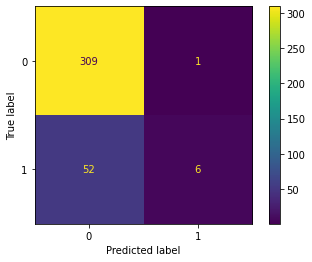

In [21]:
# 1로 예상하는 케이스가 저조 → predict_proba를 활용한 조절 필요
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [22]:
# 참고 : RandomForest 수행
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0, n_jobs=-1).fit(X_train, y_train)
rf_clf.score(X_test, y_test), roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])

(0.8586956521739131, 0.7243604004449389)

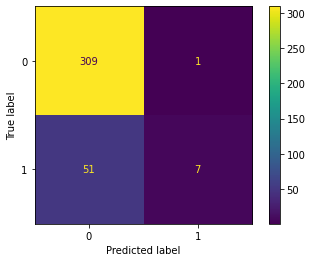

In [23]:
# 1로 예상하는 케이스가 저조 → predict_proba를 활용한 조절 필요
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)

In [24]:
# predict probability를 0.6을 기준으로
y_hat = np.where(logreg.predict_proba(X_test)[:, 0] >= 0.6, 0, 1)
y_hat

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8532608695652174


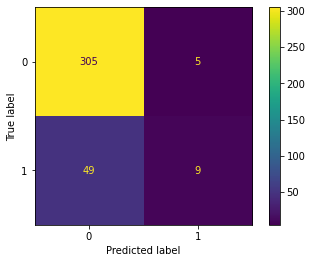

In [25]:
# prediction proba 0.6 기준 confusion matrix와 accuracy score 확인
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
print(accuracy_score(y_test, y_hat))

In [26]:
# 참고 : RandomForest 기준 predict probability를 0.6을 기준으로
y_hat_rf = np.where(rf_clf.predict_proba(X_test)[:, 0] >= 0.6, 0, 1)
y_hat_rf

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8586956521739131


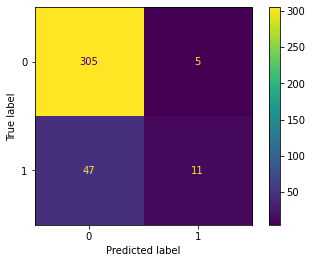

In [27]:
# 참고 : RandomForest 기준 prediction proba 0.6 기준 confusion matrix와 accuracy score 확인
# RandomForest가 좀 더 유의미
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_rf)
print(accuracy_score(y_test, y_hat_rf))

In [28]:
# RandomForest 기준 feature importances 확인
df_feature_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_fa.columns, columns=['Importance'])
df_feature_importances

,Importance
ManagingPosition,0.123391
WorkExp,0.106630
HRPosition,0.053287
SalesPosition,0.065884
Performance,0.059801
Divorced_StockOption,0.089915
MoveFrequent,0.076354
HighJobLevel,0.062221
TravelFrequent,0.070550
GenderFemale,0.062280


In [29]:
# Logistic Regression의 coefficient 확인으로 Attrition에 positive 영향을 주는 요소 확인
# Travel Frequent가 가장 유의미하게 Attrition에 positive 영향. Sales 역시 Attrition의 경향성 존재
# 반대로 ManagingPosition 및 WorkExp 등이 negative 영향
pd.DataFrame(logreg.coef_.T, index=X_fa.columns, columns=['Coefficient'])

,Coefficient
ManagingPosition,-0.587676
WorkExp,-0.418412
HRPosition,0.103476
SalesPosition,0.161238
Performance,-0.018216
Divorced_StockOption,-0.380596
MoveFrequent,0.075864
HighJobLevel,-0.353448
TravelFrequent,0.317842
GenderFemale,-0.132758


In [30]:
# statsmodels.formula.api를 통한 모델 재확인 → significance 여부 등
# target값이 category 형식이면 에러 발생 → float or int로 수정해줘야
# 각 feature들의 p_value 확인으로 90% confidence level을 기준으로 유의하지 않은 feature들 확인
# no significance : HRPostion, Performance, MoveFrequent, GenderFemale, HighEducation
data = pd.concat([X_train, y_train.astype('int')], axis=1)
formula = 'Attrition ~ ManagingPosition + WorkExp + HRPosition + SalesPosition + Performance + Divorced_StockOption + MoveFrequent + HighJobLevel + TravelFrequent + GenderFemale + MajorMedical + HighEducation + EnvSatisfied + MajorMarkeing'
model = smfa.logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.389950
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1087
Method:                           MLE   Df Model:                           14
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1211
Time:                        21:46:12   Log-Likelihood:                -429.72
converged:                       True   LL-Null:                       -488.94
Covariance Type:            nonrobust   LLR p-value:                 1.281e-18
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9703      0.106    -18.547      0.000      -2.178      -1.762
ManagingPosition        -0.5878      0.109     -5.415      0.000      -0.800      -0.375
WorkExp                 -0.4185      0.096     -4.363      0.000      -0.606      -0.230
HRPosition               0.1035      0.076      1.367      0.172      -0.045       0.252
SalesPosition            0.1613      0.086      1.877      0.061      -0.007       0.330
Performance             -0.0182      0.090     -0.202      0.840      -0.195       0.158
Divorced_StockOption    -0.3806      0.097     -3.917      0.000      -0.571      -0.190
MoveFrequent             0.0759      0.083      0.918      0.359      -0.086       0.238
HighJobLevel            -0.3535      0.132     -2.668      0.008      -0.613      -0.094
TravelFrequent           0.3179      0.078      4.054      0.000       0.164       0.472
GenderFemale            -0.1328      0.090     -1.476      0.140      -0.309       0.044
MajorMedical            -0.1860      0.091     -2.041      0.041      -0.365      -0.007
HighEducation           -0.1245      0.092     -1.357      0.175      -0.304       0.055
EnvSatisfied            -0.1884      0.091     -2.060      0.039      -0.368      -0.009
MajorMarkeing            0.1337      0.081      1.652      0.099      -0.025       0.292
========================================================================================
"""